In [1]:
!pip install mecab
!pip install ipadic

In [28]:
import re
import ipadic
import subprocess
import unicodedata
import pandas as pd
import MeCab
from wordcloud import WordCloud
import json

In [3]:
# データの読み込み
df = pd.read_csv("./sample_data.csv")
# ユニコード正規化とアルファベットの小文字統一
df.text = df.text.str.normalize("NFKC").str.lower()
# 改行コードを取り除く
df.text = df.text.str.replace("\n", " ")
# エラーになる文字があるので取り除く (ライブドアニュースコーパス使う場合だけの処理。普通は不要)
df.text = df.text.str.replace("\u2028", "")

# 辞書のパス取得
tagger = MeCab.Tagger(ipadic.MECAB_ARGS)

# ひらがなのみの文字列にマッチする正規表現
kana_re = re.compile("^[ぁ-ゖ]+$")

# 分かち書きして、ひらがな以外を含む 名詞/動詞/形容詞 を返す関数
def mecab_tokenizer(text):
    # 分かち書き
    parsed_lines = tagger.parse(text).splitlines()[:-1]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]
    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 名詞/動詞/形容詞に絞り込み
    target_pos = ["名詞", "動詞", "形容詞"]
    token_list = [t for t, p in zip(token_list, pos) if (p in target_pos)]
    # ひらがなのみの単語を除く
    token_list = [t for t in token_list if not kana_re.match(t)]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]
    # 半角スペースを挟んで結合する。
    result = " ".join(token_list)
    # 念のためもう一度ユニコード正規化
    result = unicodedata.normalize("NFKC", result)
    return result
    

In [4]:
# 形態素解析
df["tokens"] = df.text.apply(mecab_tokenizer)
# wordcloud入力データ用に連結する
text_data = " ".join(df["tokens"])

# ワードクラウドのオブジェクト生成
wc = WordCloud(
        width=600,  # 幅
        height=400,  # 高さ
        prefer_horizontal=0.9,  # 横書きで配置することを試す確率 (デフォルト0.9)
        background_color='white',  # 背景色
        include_numbers=False,  # 数値だけの単語を含まない
        colormap='tab20',  # 文字色のカラーマップ指定
        regexp=r"\w{2,}",  # 2文字以上の単語のみ含む
        relative_scaling=1,  # 頻度のみで文字サイズを決める
        collocations=False,  # bi-gramを考慮しない
        max_font_size=60,  # 最大フォントサイズ
        random_state=42,  # 乱数の初期値
    ).generate(text_data)

# この時点で作成できたwordcloudを確認する場合は以下の関数を実行。
ex_text = wc.to_svg()
ex_img = wc.to_image()
# 出力省略


In [12]:
df

,text,wight,tokens
0,サル痘の潜伏期間は7~14日(最大5~21日)とされており、潜伏期間の後、発熱、頭痛、リンパ...,NaN,サル 痘 潜伏 期間 7 14 日 最大 5 21 日 潜伏 期間 後 発熱 頭痛 リンパ ...
1,#東京2020大会 #1周年記念 セレモニー日本代表選手団 163 名等による入場パレードや...,52.0,東京 2020 大会 1 周年 記念 セレモニー 日本 代表 選手 団 163 名 等 入場...
2,日本の友達と淡路島に旅行へ行ったんだけど、最初に全員から1万円ずつ集めて財布に入れて、ご飯を...,20.0,日本 友達 淡路島 旅行 行く 最初 全員 1 万 円 集める 財布 入れる ご飯 買う 時...
3,もしかすると、ネコ科の仔ってみんな、トラもライオンもヒョウもピューマもチータもカラカルもサー...,32.0,ネコ 科 仔 トラ ライオン ヒョウ ピューマ チータ カラカル サー バル マヌル イリオ...


In [33]:
tokens = df.tokens
texts = df.text
i = 0
print(i)
type(i)

dic = {}

for token in tokens:
    wordend = token.split()
    for word in wordend:
       dic.setdefault(word,set())
       dic[word].add(i)
    i += 1

for key in dic.keys():
   dic[key] = list(dic[key])
       


0


In [34]:
result = {"dic":dic,"posts":list(texts),"wordcloud":ex_text}
print(result)


{'dic': {'サル': [0], '痘': [0], '潜伏': [0], '期間': [0], '7': [0], '14': [0], '日': [0], '最大': [0], '5': [0], '21': [0], '後': [0], '発熱': [0], '頭痛': [0], 'リンパ': [0], '節': [0], '腫脹': [0], '筋肉': [0], '痛': [0], '症状': [0], '0': [0], '続く': [0], '1': [0, 1, 2], '3': [0], '発疹': [0], '出現': [0], '発症': [0], '2': [0], '4': [0], '週間': [0], '治癒': [0], '24': [0], '東京': [1], '2020': [1], '大会': [1], '周年': [1], '記念': [1], 'セレモニー': [1], '日本': [1, 2], '代表': [1], '選手': [1], '団': [1], '163': [1], '名': [1], '等': [1], '入場': [1, 2], 'パレード': [1], 'アスリート': [1], '子供': [1], '混合': [1], 'チーム': [1], 'リレー': [1], 'ライブ': [1], 'パフォーマンス': [1], '会場': [1], '盛大': [1], '盛り上がる': [1], '来場': [1], '皆さま': [1], 'youtubelive': [1], '配信': [1], '視聴': [1], '友達': [2], '淡路島': [2], '旅行': [2], '行く': [2], '最初': [2], '全員': [2], '万': [2], '円': [2], '集める': [2], '財布': [2], '入れる': [2], 'ご飯': [2], '買う': [2], '時': [2], '移動': [2], '料': [2], '使う': [2], '支払う': [2], '日本人': [2], '天才': [2], '思う': [2], '余る': [2], '個人': [2], 'アイデア': [2], 'ネコ': [3], '科': [3], '仔

In [35]:
print(json.dumps(result))

{"dic": {"\u30b5\u30eb": [0], "\u75d8": [0], "\u6f5c\u4f0f": [0], "\u671f\u9593": [0], "7": [0], "14": [0], "\u65e5": [0], "\u6700\u5927": [0], "5": [0], "21": [0], "\u5f8c": [0], "\u767a\u71b1": [0], "\u982d\u75db": [0], "\u30ea\u30f3\u30d1": [0], "\u7bc0": [0], "\u816b\u8139": [0], "\u7b4b\u8089": [0], "\u75db": [0], "\u75c7\u72b6": [0], "0": [0], "\u7d9a\u304f": [0], "1": [0, 1, 2], "3": [0], "\u767a\u75b9": [0], "\u51fa\u73fe": [0], "\u767a\u75c7": [0], "2": [0], "4": [0], "\u9031\u9593": [0], "\u6cbb\u7652": [0], "24": [0], "\u6771\u4eac": [1], "2020": [1], "\u5927\u4f1a": [1], "\u5468\u5e74": [1], "\u8a18\u5ff5": [1], "\u30bb\u30ec\u30e2\u30cb\u30fc": [1], "\u65e5\u672c": [1, 2], "\u4ee3\u8868": [1], "\u9078\u624b": [1], "\u56e3": [1], "163": [1], "\u540d": [1], "\u7b49": [1], "\u5165\u5834": [1, 2], "\u30d1\u30ec\u30fc\u30c9": [1], "\u30a2\u30b9\u30ea\u30fc\u30c8": [1], "\u5b50\u4f9b": [1], "\u6df7\u5408": [1], "\u30c1\u30fc\u30e0": [1], "\u30ea\u30ec\u30fc": [1], "\u30e9\u30a4\

In [5]:
ex_text

'<svg xmlns="http://www.w3.org/2000/svg" width="600" height="400">\n<style>text{font-family:\'Droid Sans Mono\';font-weight:normal;font-style:normal;}</style>\n<rect width="100%" height="100%" style="fill:white"></rect>\n<text transform="translate(186,57)" font-size="60" style="fill:rgb(127, 127, 127)">日本人</text>\n<text transform="translate(371,94)" font-size="24" style="fill:rgb(127, 127, 127)">潜伏</text>\n<text transform="translate(100,285)" font-size="24" style="fill:rgb(174, 199, 232)">期間</text>\n<text transform="translate(407,35)" font-size="24" style="fill:rgb(174, 199, 232)">発熱</text>\n<text transform="translate(191,318)" font-size="24" style="fill:rgb(31, 119, 180)">日本</text>\n<text transform="translate(133,344)" font-size="24" style="fill:rgb(127, 127, 127)">入場</text>\n<text transform="translate(93,253)" font-size="24" style="fill:rgb(196, 156, 148)">皆さま</text>\n<text transform="translate(147,22)" font-size="24" style="fill:rgb(199, 199, 199)">買う</text>\n<text transform="transl

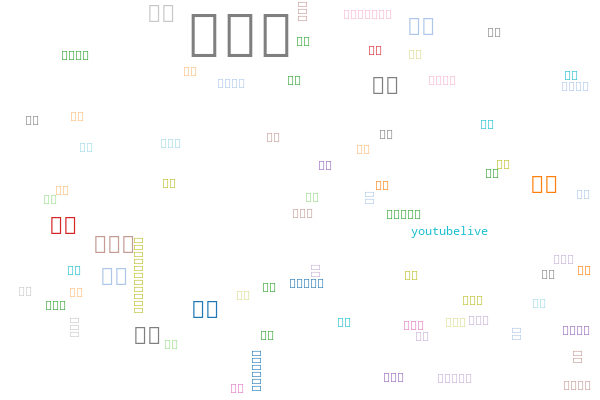

In [6]:
ex_img